In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import KFold
import os
import os, shutil 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'
data = pd.read_csv(path+'icml_face_data.csv')
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
classes = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [ ]:
X = data.emotion
kf = KFold(n_splits=6)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

In [ ]:
print(data)

In [ ]:
# Function to parse data into right format
# Output: Image in right shaped and normalized + labels
def parse_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48)) # 1
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) # 1
        image_array[i] = image
        
    return image_array, image_label

# Splitting the data into train, validation and testing set thanks to Usage column
train_imgs, train_lbls = parse_data(data[data[" Usage"] == "Training"])
val_imgs, val_lbls = parse_data(data[data[" Usage"] == "PrivateTest"])
test_imgs, test_lbls = parse_data(data[data[" Usage"] == "PublicTest"])

In [ ]:
train_images = train_imgs.reshape((train_imgs.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_imgs.reshape((val_imgs.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_imgs.reshape((test_imgs.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [ ]:
print("train shape", np.shape(train_imgs))
print("validation shape", np.shape(val_imgs))
print("validatio shape", np.shape(val_imgs))

In [ ]:
print(train_imgs)

Image files generation

In [ ]:
# os.mkdir("/kaggle/working/imgs")
# data = np.array(train_imgs[:5])
# i = 0
# for px_map in data:
#     i = i + 1
#     px_map = np.reshape(px_map, (48, 48))
#     image = Image.fromarray(px_map)
#     image = image.convert('RGB')
#     image.save('/kaggle/working/imgs/'+str(i)+'.bmp')

https://scikit-learn.org/stable/modules/cross_validation.html

MLP model

In [ ]:
# Building a MLP model based on LeNet architecture 
model_mlp = keras.Sequential()
model_mlp.add(layers.Flatten(input_shape=(48, 48, 1)))
model_mlp.add(layers.Dense(units=120, activation='relu'))
model_mlp.add(layers.Dense(units=84, activation='relu'))
model_mlp.add(layers.Dense(units=7, activation = 'softmax'))
model_mlp.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])
model_mlp.summary()

In [ ]:
# Training the model, and validating
model_mlp.fit(train_imgs, train_lbls, 
          epochs=10, batch_size=32, 
          validation_data=(val_imgs, val_lbls), verbose=1)

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(train_lbls)
val_labels = to_categorical(val_lbls)
test_labels = to_categorical(test_lbls)

CNN model

In [ ]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(7, activation='softmax'))

In [ ]:
model_cnn.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

In [ ]:
history = model_cnn.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = classes,
                    epochs=100,
                    batch_size=32)

In [ ]:
#Train accuracy and validation accuracy vs epoch graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_prob = model_cnn.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_lbls)

print(test_accuracy)

In [ ]:
conf_mat = confusion_matrix(test_lbls, test_pred)
pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

1. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='elu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='elu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='elu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='elu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-3), epochs=50, batch_size=32<br>
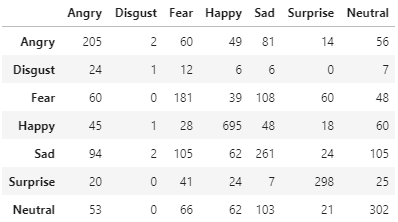 <br>
2. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-3), epochs=50, batch_size=512<br>
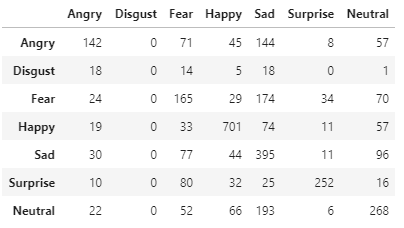 <br>
3. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-3), epochs=50, batch_size=32<br>
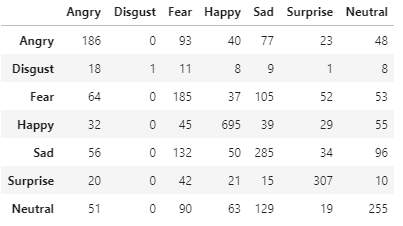 <br>
4. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-6), epochs=12, batch_size=512<br>
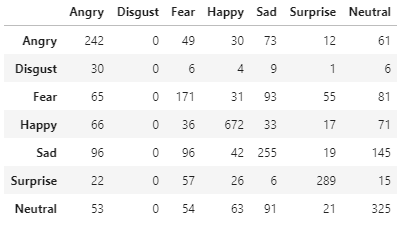 <br>
5. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-6), epochs=12, batch_size=512<br>
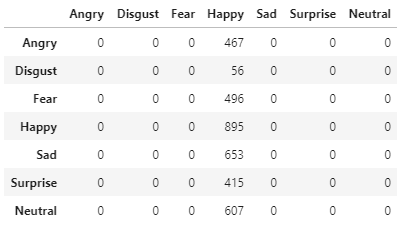 <br>
6. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-3), epochs=12, batch_size=512<br>
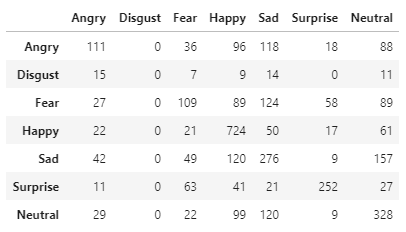 <br>
7. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='selu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='selu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='selu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='selu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-3), epochs=12, batch_size=512<br>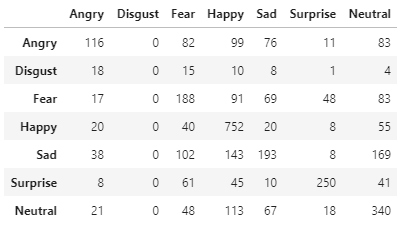<br>
8. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='elu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='elu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='elu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='elu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-3), epochs=100, batch_size=32<br>
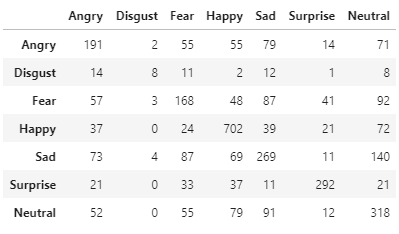<br>
9. model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPool2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='selu'))
model_cnn.add(layers.Dense(7, activation='softmax')), optimizers.Adam(lr=1e-3), epochs=100, batch_size=32<br>
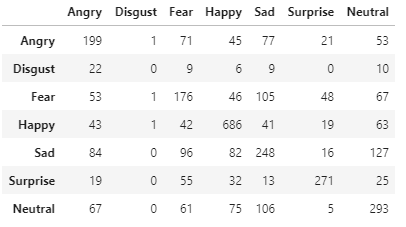

Крос-валідація: при зміні параметру n_splits змінюється розмірність матриці. В нашому випадку він дорівнює 6, тобто в нас є 6 вибірок на які розподілений наш датасет. Ми розглядаємо 6 емоцій тому що так вибірка оцінки якості моделей буде еквавілентна.<br>
Згорткова нейронна мережа: при зміна кількості шарів майже не впливає на результат, але при збільшенні кількості нейронів в шарах до 128 в деяких функціях ЗНМ не працює, зміна видів функцій активації: використовуючи sigmoid дані сильно збиваються і остаточі втрати дуже великі, що призводить до overfitting, оскільки в нас не бінарна кількість даних.<br>

1. В чому призначення різних типів шарів згорткових нейромереж?<br>
Згортковий шар є основним будівельним блоком ЗНМ.<br>Агрегувальний шар слугує поступовому скороченню просторового розміру представлення для зменшення кількості параметрів та об'єму обчислень у мережі, і відтак також для контролю перенавчання.<br>Шар зрізаних лінійних вузлів посилює нелінійні властивості функції ухвалення рішення і мережі в цілому, не зачіпаючи рецептивних полів згорткового шару.<br>Нейрони у повноз'єднаному шарі мають з'єднання з усіма збудженнями попереднього шару, як це можна бачити у звичайних нейронних мережах. Їхні збудження відтак може бути обчислювано матричним множенням, за яким слідує зсув упередженості.<br>Шар втрат визначає, як тренування штрафує відхилення між передбаченими та справжніми мітками, і є, як правило, завершальним шаром. Для різних завдань у ньому можуть використовувати різні функції втрат (начастіше: softmax та sigmoid).<br>
2. Які основні етапи типового проєкту машинного навчання?<br>
Бізнес-аналіз, аналіз та підготовка даних, моделювання, оцінка рішення, впровадження.